In [3]:
# import the necessary packages
import os
import torch

# DEVICE AGNOSTIC
#### set device to 'cpu' or 'cuda' (GPU) based on availability
#### for model training and testing
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MODEL HYPERPARAMETER
LR = 0.001             # learning rate for the model

PATIENCE = 2           # early stopping during model training where training is stopped 
                       # when performance on a validation dataset does not improve 
                       # STOP The training when result is same for 2 consecutive epochs
        
IMAGE_SIZE = 512        # defines that the size of image is 256x256
CHANNELS = 3           # defines that image's color channel is 3
BATCH_SIZE = 16        # defines that 16 training examples are used in one iteration before 
                       # updating the weight and biases of network 
    
NUM_WORKERS = os.cpu_count()     # for parallel processing
EMBEDDING_DIM = 2      # defines size of the embedding space

EPOCHS = 200            # number of complete passes through the entire training dataset
                       # i.e. model is trained on the whole dataset 10 times

    
# DATASET PATH
# CELEBFACE_ROOT = "./data/img_align_celeba"
CELEBFACE_ROOT = "/kaggle/input/celebface-dataset/dataset_new/"



# OUTPUT DIRECTORY
# output_dir = "output"
# os.makedirs("output", exist_ok=True)

# # creates the training_progress directory inside the output directory
# training_progress_dir = os.path.join(output_dir, "training_progress")
# os.makedirs(training_progress_dir, exist_ok=True)


# # creates the model_weights directory inside the output directory
# # for storing autoencoder weights
# model_weights_dir = os.path.join(output_dir, "model_weights")
# os.makedirs(model_weights_dir, exist_ok=True)


In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [5]:
print(f" cuda count : {torch.cuda.device_count()}")
print(f" cuda name : {torch.cuda.get_device_name()}")

 cuda count : 1
 cuda name : Tesla P100-PCIE-16GB


---
# **Creating dataset and dataloader out of photos**
- celebface_dataset
    - celeb_train_dataset -> `celeb_train_dataloader`
    - celeb_val_dataset   -> `celeb_val_dataloader`
    
    - `celeb_noisy_train_dataloader`
    - `celeb_noisy_val_dataloader`
---

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Define transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Path to the CelebFace dataset directory

# Create dataset using ImageFolder
celebface_dataset = datasets.ImageFolder(
                                        root=CELEBFACE_ROOT,
                                        transform=transform
                                        )

# Split dataset into training and validation sets
train_size = int(0.8 * len(celebface_dataset))  # 80% for training
val_size = len(celebface_dataset) - train_size  # 20% for validation
# celeb_train_dataset, celeb_val_dataset = celebface_dataset[:train_size], celebface_dataset[train_size:val_size]
celeb_train_dataset, celeb_val_dataset = random_split(celebface_dataset, [train_size, val_size])

# Create DataLoader for training set
# batch_size = 64
### Train dataloader
celeb_train_dataloader = DataLoader(
                                    dataset=celeb_train_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

## Test dataloader
# Create DataLoader for validation set
celeb_val_dataloader = DataLoader(
                                    dataset=celeb_val_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

for images, labels in celeb_train_dataloader:
    # Do something with the training data
    print("Training data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break 

for images, labels in celeb_val_dataloader:
    # Do something with the validation data
    print("Validation data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break 


Training data:
torch.Size([16, 3, 512, 512])
torch.Size([16])
Validation data:
torch.Size([16, 3, 512, 512])
torch.Size([16])


---
# **Creating Noisy dataloader** 
---

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_std):
        self.dataset = dataset
        self.noise_std = noise_std

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Add noise to the image
        noisy_image = image + torch.randn_like(image) * self.noise_std
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are in [0, 1] range

        return noisy_image, label

def create_noisy_dataloader(dataset, noise_std, batch_size=BATCH_SIZE):
    # Create noisy dataset
    noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=noisy_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader


---
# **Creaing Blurry Image dataset**
---

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2

class BlurryDataset(Dataset):
    def __init__(self, dataset, blur_radius):
        self.dataset = dataset
        self.blur_radius = blur_radius

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Convert PIL image to numpy array
        image_np = transforms.ToPILImage()(image)
        image_np = np.array(image_np)

        # Apply blur using cv2.blur
        blurry_image = cv2.blur(image_np, (self.blur_radius, self.blur_radius))

        # Convert numpy array back to tensor
        blurry_image = transforms.ToTensor()(blurry_image)

        return blurry_image, label
    
def create_blurry_dataloader(dataset, blur_radius, batch_size=BATCH_SIZE):
    # Create noisy dataset
    blurry_dataset = BlurryDataset(dataset=dataset, blur_radius=blur_radius)
#     noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=blurry_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader



In [9]:
# # blurry train dataloader
# blur_radius = 20
# celeb_blurry_train_dataloader = create_blurry_dataloader(dataset=celeb_train_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)
# celeb_blurry_val_dataloader = create_blurry_dataloader(dataset=celeb_val_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)


# noisy train dataloader
noise_std = 0.6
celeb_noisy_train_dataloader = create_noisy_dataloader(celeb_train_dataset, noise_std, BATCH_SIZE)
celeb_noisy_val_dataloader = create_noisy_dataloader(celeb_val_dataset, noise_std, BATCH_SIZE)


In [10]:
print(f"""
Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : {len(celeb_train_dataloader)*BATCH_SIZE}
Clean Val dataloader length   : {len(celeb_val_dataloader)*BATCH_SIZE}
Total Clean images            : {len(celeb_train_dataloader)*BATCH_SIZE + len(celeb_val_dataloader)*BATCH_SIZE}


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_noisy_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_noisy_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_noisy_train_dataloader)*BATCH_SIZE + len(celeb_noisy_val_dataloader)*BATCH_SIZE}


""")


"""
Blurry Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_blurry_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_blurry_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_blurry_train_dataloader)*BATCH_SIZE + len(celeb_blurry_val_dataloader)*BATCH_SIZE}

"""
!echo 'Total images in dataset : '$( ls -al /kaggle/input/celebface-dataset/dataset_new/dataset_new/*.jpg | wc -l )


Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : 8000
Clean Val dataloader length   : 2000
Total Clean images            : 10000


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : 8000
Noisy Val dataloader length   : 2000
Total Noisy images            : 10000



Total images in dataset : 10000


---
# **Displaying Images from dataloaders**

### Dataloaders include

- celeb_train_dataloader
- celeb_noisy_train_dataloader
- celeb_val_dataloader
- celeb_noisy_val_dataloader

---

Clean Train Images:


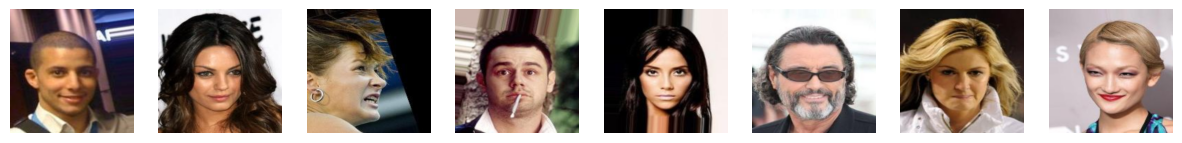

Noisy Train Images:


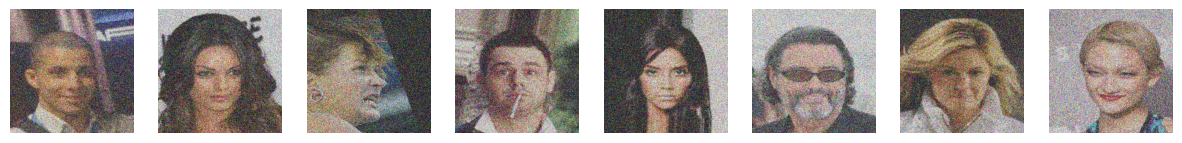




Clean Validation Images:


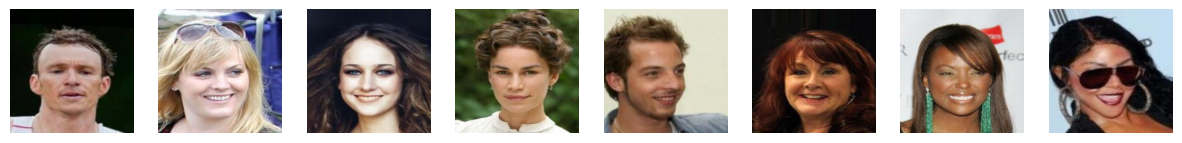

Noisy Validation Images:


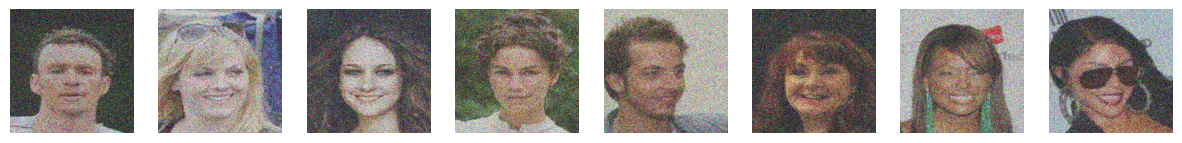

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataloader, num_images=8):
    # Get a batch of images
    for i, (images, _) in enumerate(dataloader):
        # Display images from the batch
        plt.figure(figsize=(15, 5))
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            image = images[j].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions
            plt.imshow(image)
            plt.axis('off')
        plt.show()
        break 
        
        
print("Clean Train Images:")
show_images(celeb_train_dataloader)

# print("Blurry Train Images:")
# show_images(celeb_blurry_train_dataloader)

print("Noisy Train Images:")
show_images(celeb_noisy_train_dataloader)





print("\n\n\nClean Validation Images:")
show_images(celeb_val_dataloader)

# print("Blurry Validation Images:")
# show_images(celeb_blurry_val_dataloader)

print("Noisy Validation Images:")
show_images(celeb_noisy_val_dataloader)

# **Convolutional AutoEncoder Architecture**

---
## **Convolutional Variational Autoencoder (v2)** 
### 4 layers in encoder network
### 4 layers in decoder network
---

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_v2(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_v2, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
                                   in_channels=img_channels, 
                                   out_channels=32, 
                                   kernel_size=4, 
                                   stride=2, 
                                   padding=1
                                  )
        
        self.enc_conv2 = nn.Conv2d(
                                    in_channels=32, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )
        self.enc_conv3 = nn.Conv2d(
                                    in_channels=64, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )
        self.enc_conv4 = nn.Conv2d(
                                    in_channels=128, 
                                    out_channels=256, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )

        # Determine the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 256 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
                                            in_channels=256, 
                                            out_channels=128, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv2 = nn.ConvTranspose2d(
                                            in_channels=128, 
                                            out_channels=64, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv3 = nn.ConvTranspose2d(
                                            in_channels=64, 
                                            out_channels=32, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv4 = nn.ConvTranspose2d(
                                            in_channels=32, 
                                            out_channels=img_channels, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(4):  # 4 convolutional layers in encoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = x.view(-1, 256 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 256, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = torch.sigmoid(self.dec_conv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


---
# **Model Summary**
---

In [16]:
from torchinfo import summary

model_CVAE_v2 = CVAE_v2(img_size=512)
summary(model_CVAE_v2, input_size=[BATCH_SIZE, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE_v2                                  [16, 3, 512, 512]         --
├─Conv2d: 1-1                            [16, 32, 256, 256]        1,568
├─Conv2d: 1-2                            [16, 64, 128, 128]        32,832
├─Conv2d: 1-3                            [16, 128, 64, 64]         131,200
├─Conv2d: 1-4                            [16, 256, 32, 32]         524,544
├─Linear: 1-5                            [16, 256]                 67,109,120
├─Linear: 1-6                            [16, 256]                 67,109,120
├─Linear: 1-7                            [16, 262144]              67,371,008
├─ConvTranspose2d: 1-8                   [16, 128, 64, 64]         524,416
├─ConvTranspose2d: 1-9                   [16, 64, 128, 128]        131,136
├─ConvTranspose2d: 1-10                  [16, 32, 256, 256]        32,800
├─ConvTranspose2d: 1-11                  [16, 3, 512, 512]         1,539
Total params: 202,969,283
T

In [17]:
model_CVAE_v2

CVAE_v2(
  (enc_conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_fc_mu): Linear(in_features=262144, out_features=256, bias=True)
  (enc_fc_logvar): Linear(in_features=262144, out_features=256, bias=True)
  (dec_fc): Linear(in_features=256, out_features=262144, bias=True)
  (dec_conv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

---
## **Loss function**
---

In [21]:
def loss_function(recon_img, input_img, mu, logvar, beta=1.0):
#     print(f"input img size = {input_img.shape}")
#     print(f"reconstructed img size = {recon_img.shape}")
    input_img = input_img.view(recon_img.size())
#     print(f"after view input img size = {input_img.shape}")
    
    BCE = nn.functional.binary_cross_entropy(
        recon_img, input_img, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + beta * KLD

In [22]:
# set random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

---
## **Utility functions for training**
- `train_step()` for training model
- `test_step()` for validation model
- `train()` combines training and validating utilities 
---

In [24]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               clean_train_dataloader: torch.utils.data.DataLoader,
               noisy_train_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer, 
               device: torch.device,
               loss_fn = loss_function
              ):
    loss_history = []
    train_loss = 0
    num = 1
    
    # 1. model 
    model.train()
    total_loss = 0.0
    for (clean_img, _), (noisy_img, _) in zip(clean_train_dataloader, noisy_train_dataloader):
        clean_img, noisy_img = clean_img.to(DEVICE), noisy_img.to(DEVICE)

        # 2. forward pass 
        recon_img, mu, logVar = model(noisy_img)

        if num % 100 == 0:
            print(f"{num}, ", end="")
        num += 1

        # 3. calculate the loss
        loss = loss_fn(recon_img=recon_img, 
                       input_img=clean_img, 
                       mu=mu, 
                       logvar=logVar)

        # 4. optimizer zero grad 
        optimizer.zero_grad()

        # 5. loss backward 
        loss.backward()
        
        ### accumulating the training loss
        train_loss += loss.item()

        # 6. optimizer step 
        optimizer.step()
        
        average_loss = total_loss / len(clean_train_dataloader.dataset)
    train_loss = train_loss / len(clean_train_dataloader.dataset)
    loss_history.append(average_loss)
    

    return train_loss

In [25]:
def test_step(model: torch.nn.Module,
             clean_test_dataloader: torch.utils.data.DataLoader,
             noisy_test_dataloader: torch.utils.data.DataLoader,
             loss_fn,
             device: torch.device):
  ### TESTING
  test_loss = 0


  # Put the model into eval mode
  model.eval()

  # turn on inference mode
  with torch.inference_mode():
#     for X, y in data_loader:
    for (clean_test_img, _), (noisy_test_img, _) in zip(clean_test_dataloader, noisy_test_dataloader):
        # put the data X and y into  device
        clean_test_img, noisy_test_img = clean_test_img.to(device), noisy_test_img.to(device)

        # 1. forward pass (outputs raw logits )
        reconstructed_test_img, mu, logVar = model(noisy_test_img)

        # 2. calculate  the loss (accumulatively)
        loss = loss_fn(recon_img=reconstructed_test_img, input_img=clean_test_img, mu=mu, logvar=logVar)
#         loss = loss_fn(reconstructed_test_img, clean_test_img)
        test_loss += loss.item()

        # 3. calculate accuracy
#         test_pred_labels = test_pred_logits.argmax(dim=1)
#         test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)      # go from raw logits -> prediction labels

    # calculate the test loss and average per batc/h
    test_loss /= len(clean_test_dataloader.dataset)

    # calculate the test accuracy average per batch
#     test_acc /= len(data_loader)

  # print what's happening
  # print(f"\nTest loss: {train_loss:.4f}, Test accuracy: {test_acc:.4f}% \n")
    return test_loss

In [26]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          clean_train_dataloader: torch.utils.data.DataLoader,
          noisy_train_dataloader: torch.utils.data.DataLoader,
          clean_val_dataloader: torch.utils.data.DataLoader,
          noisy_val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler,
          loss_fn,
          epochs: int,
          device : torch.device = DEVICE):
    results = {"train_loss": [],
#             "train_acc": [],
            "test_loss": [],
#             "test_acc": []
              }
    best_val_loss = float('inf')  # Initialize with a very high value
    consecutive_same_loss_count = 0
    prev_loss = None

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model = model,
                            clean_train_dataloader = clean_train_dataloader,
                            noisy_train_dataloader = noisy_train_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            device = DEVICE
                           )
        if (epoch + 1) % 20 == 0 and epoch != 0:
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/model_{epoch}epoch_trained.pth"

            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # Save the model state dictionary to the specified path
            torch.save(model_state_dict, save_path)

      
        test_loss = test_step(model = model,
                              clean_test_dataloader = clean_val_dataloader,
                              noisy_test_dataloader = noisy_val_dataloader,
                              loss_fn = loss_fn,
                              device = DEVICE)

        # Update learning rate
#         scheduler.step()

        # Save the model if the validation loss is improved
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/best_model.pth"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model_state_dict, save_path)

        print(f"Epoch: {epoch + 1} | Train loss : {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        results["train_loss"].append(train_loss)
    #     results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
    #     results["test_acc"].append(test_acc)

        
        # Check if the current epoch has the same loss as the previous epoch
        if prev_loss is not None and train_loss == prev_loss:
            consecutive_same_loss_count += 1
        else:
            consecutive_same_loss_count = 0

        prev_loss = train_loss

        # If there are 4 consecutive epochs with the same loss, break out of the loop
        if consecutive_same_loss_count == 4:
            print("Training halted due to 4 consecutive epochs with the same loss.")
            break

    return results


---

### **Loads the `state_dict` of from `*.pth` file if passed as argument and starts training the model**

---

In [27]:
def train_model(model, epochs, optimizer, state_dict_file=None):
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    if state_dict_file:
        print(f"{state_dict_file} present!!!")
        state_dict = torch.load(state_dict_file)
        # If the model was trained using DataParallel, you need to remove the 'module.' prefix
        # from all keys in the state_dict
        if next(iter(state_dict.keys())).startswith("module"):
            state_dict = {key[7:]: value for key, value in state_dict.items()}

            # Load the state_dict into the model
            model.load_state_dict(state_dict)

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=PATIENCE, verbose=True
    )



    model_loss_results = train(model = model, 
                                clean_train_dataloader = celeb_train_dataloader, 
                                noisy_train_dataloader = celeb_noisy_train_dataloader, 
                                clean_val_dataloader = celeb_val_dataloader, 
                                noisy_val_dataloader = celeb_noisy_val_dataloader,
                                optimizer = optimizer,
                                scheduler = scheduler,
                                loss_fn = loss_function, 
                                epochs = epochs, 
                                device = DEVICE
                               )
    return model_loss_results

---
## **Below code trains the model**
---

In [20]:
model_CVAE_v2 = CVAE_v2(img_size=512).to(DEVICE)
optimizer = torch.optim.Adam(model_CVAE_v2.parameters(), lr=LR)          # lr = alpha {learning rate}

# def train_model(model, epochs, optimizer, state_dict_file=None):
model_CVAE_v2_result = train_model(model=model_CVAE_v2, 
                                   epochs=EPOCHS, 
                                   optimizer=optimizer, 
#                                    state_dict_file="./models/CVAE_v1/model_6epoch_trained.pth"
                                  )

  0%|          | 0/200 [00:00<?, ?it/s]

100, 200, 300, 400, 500, Epoch: 1 | Train loss : 435012.1291 | Test Loss: 410120.3397
100, 200, 300, 400, 500, Epoch: 2 | Train loss : 405687.9680 | Test Loss: 403588.2743
100, 200, 300, 400, 500, Epoch: 3 | Train loss : 398560.7246 | Test Loss: 397050.1565
100, 200, 300, 400, 500, Epoch: 4 | Train loss : 394016.3965 | Test Loss: 394375.0890
100, 200, 300, 400, 500, Epoch: 5 | Train loss : 392077.1285 | Test Loss: 393584.4587
100, 200, 300, 400, 500, Epoch: 6 | Train loss : 390408.6292 | Test Loss: 392266.6030
100, 200, 300, 400, 500, Epoch: 7 | Train loss : 389250.5127 | Test Loss: 391539.7655
100, 200, 300, 400, 500, Epoch: 8 | Train loss : 388074.9201 | Test Loss: 390819.1323
100, 200, 300, 400, 500, Epoch: 9 | Train loss : 387111.3331 | Test Loss: 390582.5463
100, 200, 300, 400, 500, Epoch: 10 | Train loss : 386937.4264 | Test Loss: 390510.7882
100, 200, 300, 400, 500, Epoch: 11 | Train loss : 386500.4326 | Test Loss: 390076.6433
100, 200, 300, 400, 500, Epoch: 12 | Train loss : 38

---

## **Model's loss value : `train_loss` and `test_loss`**
---

In [29]:
model_CVAE_v2_result

{'train_loss': [435012.129125,
  405687.968,
  398560.724625,
  394016.3965,
  392077.1285,
  390408.6291875,
  389250.51275,
  388074.9200625,
  387111.333125,
  386937.4264375,
  386500.4325625,
  385732.4239375,
  384970.3533125,
  384758.715,
  384646.161125,
  384552.109375,
  383787.904125,
  383091.6465625,
  382628.9335,
  382948.042875,
  383450.1200625,
  383048.656,
  382830.2081875,
  382306.004875,
  381738.8435,
  381538.9560625,
  381995.204875,
  382694.1629375,
  381937.5298125,
  381061.9649375,
  380815.444,
  381308.609,
  382171.9335,
  382236.1463125,
  381324.875,
  380698.8601875,
  380908.936375,
  381635.517125,
  381214.1754375,
  381045.8584375,
  381769.1995625,
  382147.6146875,
  380955.5540625,
  379613.6629375,
  378727.2160625,
  378185.6394375,
  377855.8444375,
  377723.2963125,
  377897.6615,
  379041.5198125,
  380773.4918125,
  381985.1043125,
  383287.4804375,
  381913.1110625,
  380037.988375,
  379023.6214375,
  378643.4576875,
  378874.62275,


In [13]:
model_CVAE_v2_result = {'train_loss': [435012.129125,
  405687.968,
  398560.724625,
  394016.3965,
  392077.1285,
  390408.6291875,
  389250.51275,
  388074.9200625,
  387111.333125,
  386937.4264375,
  386500.4325625,
  385732.4239375,
  384970.3533125,
  384758.715,
  384646.161125,
  384552.109375,
  383787.904125,
  383091.6465625,
  382628.9335,
  382948.042875,
  383450.1200625,
  383048.656,
  382830.2081875,
  382306.004875,
  381738.8435,
  381538.9560625,
  381995.204875,
  382694.1629375,
  381937.5298125,
  381061.9649375,
  380815.444,
  381308.609,
  382171.9335,
  382236.1463125,
  381324.875,
  380698.8601875,
  380908.936375,
  381635.517125,
  381214.1754375,
  381045.8584375,
  381769.1995625,
  382147.6146875,
  380955.5540625,
  379613.6629375,
  378727.2160625,
  378185.6394375,
  377855.8444375,
  377723.2963125,
  377897.6615,
  379041.5198125,
  380773.4918125,
  381985.1043125,
  383287.4804375,
  381913.1110625,
  380037.988375,
  379023.6214375,
  378643.4576875,
  378874.62275,
  380452.7836875,
  382553.0649375,
  382813.9706875,
  381542.345875,
  380225.785,
  379654.2163125,
  379662.554375,
  380006.780625,
  380051.155125,
  380271.0499375,
  381206.80825,
  381850.9434375,
  381513.9985,
  380633.0770625,
  379738.9054375,
  379148.7494375,
  378794.2418125,
  378835.9569375,
  379365.984625,
  380213.4139375,
  381011.6769375,
  381554.96075,
  380883.5356875,
  380264.8010625,
  379760.5785625,
  379308.0535625,
  378892.3635,
  378757.9900625,
  378941.904125,
  379191.416625,
  379672.7838125,
  380092.959,
  380502.0455625,
  380242.44475,
  380176.1339375,
  380010.6385,
  379850.5540625,
  379499.68375,
  379001.6330625,
  378934.505125,
  379090.4536875,
  378813.6749375,
  378750.53925,
  378870.433125,
  379020.5868125,
  378865.632625,
  378552.598625,
  378238.6090625,
  378123.7736875,
  378545.3215625,
  379310.957125,
  379793.75375,
  379962.0911875,
  380290.316375,
  380155.543875,
  379774.86525,
  379177.8168125,
  378550.0533125,
  378051.107125,
  377867.8644375,
  377908.791625,
  378221.0025,
  378554.8655625,
  378590.58125,
  378947.7815625,
  379720.280375,
  380176.781875,
  380133.2166875,
  379570.9790625,
  378951.0925625,
  378392.4640625,
  378158.755125,
  378202.9871875,
  378197.6924375,
  378289.91175,
  378674.66175,
  379231.972625,
  379351.294125,
  378993.2625625,
  378611.531375,
  378215.4658125,
  377881.2805625,
  377830.8305625,
  378152.8099375,
  378397.571125,
  378506.8603125,
  378715.9041875,
  378557.916125,
  378086.6803125,
  377669.4505,
  377599.8176875,
  377616.582875,
  377733.3560625,
  377784.6356875,
  377904.2056875,
  378082.0753125,
  378126.5215,
  378029.41125,
  377953.0300625,
  377840.4420625,
  377915.2795,
  378051.7749375,
  378283.1026875,
  378465.8956875,
  378372.982875,
  378384.18675,
  378468.18375,
  378193.6403125,
  377846.022625,
  377615.6658125,
  377400.4053125,
  377327.1146875,
  377451.3456875,
  377582.692875,
  377646.9744375,
  377566.3745625,
  377606.8446875,
  377762.055,
  377477.6861875,
  377338.62975,
  377377.0013125,
  377628.066375,
  377763.040125,
  377429.4305,
  377130.3960625,
  376985.664375,
  377071.7985625,
  377147.5758125,
  377231.9985,
  377468.185,
  377736.4554375,
  377613.413,
  377264.965375,
  377019.6619375,
  376884.7940625,
  376849.2726875,
  376966.7935,
  377107.2651875,
  377059.2279375,
  377006.209125,
  376905.3835,
  376903.3270625],
 'test_loss': [410120.33975,
  403588.27425,
  397050.1565,
  394375.089,
  393584.45875,
  392266.603,
  391539.7655,
  390819.13225,
  390582.54625,
  390510.78825,
  390076.64325,
  390210.70325,
  390831.21725,
  390945.36025,
  393479.0595,
  390195.30925,
  392341.04525,
  391637.1415,
  390456.77325,
  391439.85075,
  391610.406,
  391182.93325,
  393935.8765,
  391846.97975,
  391856.7245,
  393511.59325,
  394836.77325,
  400208.48825,
  394079.15875,
  392456.38525,
  394195.00625,
  394647.851,
  392838.655,
  392001.25025,
  391900.85475,
  391923.12125,
  393054.97175,
  393570.966,
  392719.89175,
  392769.875,
  395813.37,
  394758.56375,
  394779.65575,
  395135.76625,
  395204.588,
  394985.975,
  395061.05125,
  395064.52025,
  394251.40925,
  394413.50875,
  400270.30425,
  409606.416,
  396543.00625,
  395881.05975,
  396015.344,
  395260.37425,
  395763.69475,
  398354.90875,
  401155.44825,
  402896.182,
  396677.25025,
  396676.763,
  396772.6425,
  397755.75925,
  397330.5375,
  398082.49225,
  399794.3725,
  399966.98275,
  400228.62425,
  403821.821,
  402400.7275,
  398302.9775,
  399778.0145,
  400770.75925,
  401529.92975,
  400850.3565,
  400502.96825,
  400535.62975,
  402157.99975,
  400597.9295,
  400530.56325,
  403180.98725,
  404054.968,
  402992.29275,
  400941.07075,
  399759.94175,
  401078.896,
  402803.64075,
  402192.3,
  402688.97725,
  402068.99425,
  401507.11675,
  402218.836,
  406328.0525,
  408352.442,
  405198.8525,
  402115.242,
  405071.631,
  408666.458,
  404640.9055,
  402587.893,
  403790.75575,
  404047.9245,
  404770.68775,
  405583.5285,
  404751.10275,
  404076.57875,
  402864.69575,
  403605.27925,
  403568.9335,
  404637.91925,
  407411.02575,
  409364.602,
  406574.27,
  403692.55675,
  404888.98125,
  406059.9075,
  407377.13625,
  407483.66725,
  406194.91475,
  406158.91,
  406597.747,
  408201.04075,
  408307.88675,
  408359.0395,
  407963.72525,
  407507.90225,
  405300.3815,
  405644.70325,
  405914.8275,
  406028.01825,
  405450.6825,
  404854.3935,
  405551.019,
  405600.98825,
  406828.89,
  407073.86125,
  408088.05925,
  408835.13875,
  409026.30675,
  409904.78525,
  413036.74125,
  413733.49875,
  414691.862,
  414417.63325,
  409878.97375,
  408634.8365,
  407917.98375,
  407734.90225,
  411630.426,
  412845.48225,
  413221.533,
  412989.26525,
  408856.40575,
  408722.1905,
  409659.45575,
  411224.05175,
  410503.94575,
  410515.1885,
  409783.89125,
  409847.04425,
  410421.894,
  409621.24525,
  412767.68525,
  417138.665,
  415900.89425,
  417390.25525,
  417056.839,
  418569.34,
  419082.083,
  425088.79675,
  426601.09075,
  418821.14625,
  414930.7455,
  414250.6515,
  415860.42825,
  417688.99875,
  414455.19075,
  418347.50325,
  419560.17975,
  412480.96525,
  408206.3865,
  407259.94475,
  408317.51375,
  408136.26075,
  407387.9965,
  408586.0585,
  409522.04525,
  409119.902,
  409241.268,
  408826.87825,
  408437.35675,
  407988.1325,
  408405.21875,
  409616.78875,
  408715.95175,
  408604.9695,
  408298.332,
  408623.60525,
  408065.8935]}


---
## **Plotting loss graph**

loss graph includes `train_loss` and `test_loss`

---

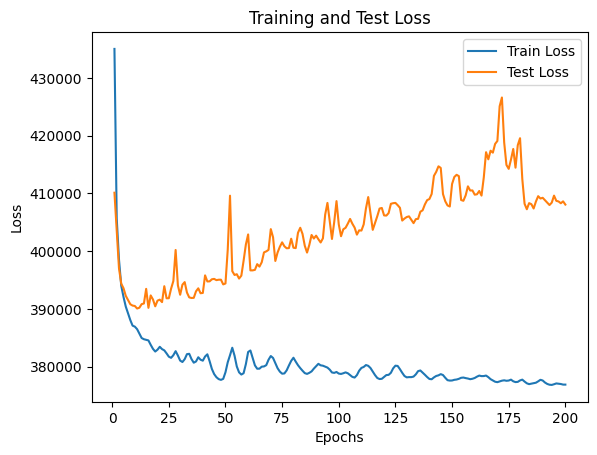

In [31]:
import matplotlib.pyplot as plt

def plot_loss(data, total_epochs):
    # Generate epochs list using total_epochs
    epochs = range(1, total_epochs + 1)
    train_loss = data["train_loss"]
    test_loss = data["test_loss"]

    # Plot train_loss and test_loss
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

total_epochs = 200  # Total number of epochs
plot_loss(model_CVAE_v2_result, EPOCHS)

---
# **Testing our best model for `CVAE_v2` architecture**

model state_dict is stored is `./models/CVAE_v2best_model.pth`

---

In [35]:
def load_and_return_model(model_path, CVAE_arch):
    model = CVAE_arch(img_size=IMAGE_SIZE).to(DEVICE)

    state_dict = torch.load(model_path)
    print(type(state_dict))

    # If the model was trained using DataParallel, the 'module.' prefix need to be removed
    # from all keys in the state_dict
    if next(iter(state_dict.keys())).startswith("module"):
        state_dict = {key[7:]: value for key, value in state_dict.items()}

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
    return model


In [1]:
index = 142

original_image = celeb_val_dataloader.dataset[index][0]

nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]

model = load_and_return_model("./models/CVAE_v2/best_model.pth",CVAE_v2)
model.eval()
with torch.inference_mode():
    reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


plt.subplot(1, 3, 1)
plt.imshow(original_image.permute(1,2,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(nosiy_image.permute(1,2,0))
plt.title('Nosiy Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.squeeze().cpu().permute(1,2,0))
plt.title('Reconstructed')
plt.axis('off')


plt.show()

NameError: name 'celeb_val_dataloader' is not defined

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torchvision
import requests 
from pathlib import Path

# Define the image path
image_path = Path("./data/asd.png")

# Download image if it does not exist
if not image_path.is_file():
    with open(image_path, "wb") as f:
        request = requests.get("https://files.saurabtharu.com.np/nihang.jpg")
        print(f"Downloading {image_path}")
        f.write(request.content)
else:
    print(f"{image_path} already exists, skipping download...")

# Read and preprocess the image
image_1 = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
image_pil = TF.to_pil_image(image_1)
transformed_image = transform(image_pil)

# Display the original and denoised images
plt.figure(figsize=(10, 5))

# Plot the original noisy input image
plt.subplot(1, 2, 1)
plt.title("Noisy input image to model")
plt.imshow(transformed_image.squeeze(0).cpu().permute(1, 2, 0))
plt.axis('off')

# Plot the denoised image
plt.subplot(1, 2, 2)
plt.title("Denoised image")
plt.imshow(denoised.squeeze(0).cpu().permute(1, 2, 0))
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

def test_model(
                    state_dict_file,
                celeb_val_dataloader = celeb_val_dataloader,
                celeb_noisy_val_dataloader = celeb_noisy_val_dataloader
              ):
    # Initialize your model architecture
    model = CVAE(img_size=IMAGE_SIZE).to(DEVICE)

    # Load the state_dict
    state_dict = torch.load(state_dict_file)
    print(type(state_dict))

    # If the model was trained using DataParallel, you need to remove the 'module.' prefix
    # from all keys in the state_dict
    if next(iter(state_dict.keys())).startswith("module"):
        state_dict = {key[7:]: value for key, value in state_dict.items()}

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
#     print(f"type of model : {type(model)}")
    

    index = 20

    original_image = celeb_val_dataloader.dataset[index][0]

    nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]
    model.eval()
    with torch.inference_mode():
        reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


    plt.subplot(1, 3, 1)
    plt.imshow(original_image.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(nosiy_image.permute(1, 2, 0))
    plt.title("Nosiy Image")
    plt.axis("off")


    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image.squeeze().cpu().permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()
    
test_model("./models/parallel_model_50epoch_trained.pth", celeb_val_dataloader, celeb_noisy_val_dataloader)
# test_model(celeb_val_dataloader, celeb_noisy_val_dataloader, './models/parallel_model_3_200epoch_trained.pth')
# test_model(celeb_val_dataloader, celeb_noisy_val_dataloader, "./models/parallel_model_3_400epoch_trained.pth")

In [ ]:
# Initialize your model architecture
model = CVAE(img_size=IMAGE_SIZE).to(DEVICE)

# Load the state_dict
state_dict = torch.load("./models/parallel_model_50epoch_trained.pth")
print(type(state_dict))

# If the model was trained using DataParallel, you need to remove the 'module.' prefix
# from all keys in the state_dict
if next(iter(state_dict.keys())).startswith("module"):
    state_dict = {key[7:]: value for key, value in T.items()}

# Load the state_dict into the model
model.load_state_dict(state_dict)


train_func(model, 50, celeb_train_dataloader, celeb_noisy_train_dataloader)

In [ ]:
test_model("./models/parallel_model_50epoch_trained.pth", celeb_val_dataloader, celeb_noisy_val_dataloader)
